# Generate data

The tools we use to digest and analyze data can often take a turn to generate data, which allows us to work out routines and algorithms without actual data, as long as we understand the anticipated data schema.

The element of randomness also helps with the testing and robustness of the data process, especially with a sufficient sample size. The comprehensiveness of the randomly generated data can often rival that of the actual data.

Suppose we are to work with some dataset that contains mobile activities across designated POIs, with a good understanding of the data schema (in the sense of columns):
* `date` - the date of mobile device activities recorded
* `hour` - the hour of the date
* `day` - the day of the week of the given date
* `name` - the name of the POI
* `address` - the street address of the POI
* `city` - the city of the POI
* `region` - the region of the POI
* `country` - the country of the POI
* `device_ids` - a list of unique device IDs that were active in the given POI
* `total_counts` - number or length of the given `device_ids`

The dataset would loosely resemble the audience data we have seen from [09 - Set operations](./09-set-operations.ipynb). However, suppose we want to work out a process to perform a similar analysis without waiting for the actual data. We may be able to work with generated data using our understanding of the data schema.

## Random Device IDs

Let's generate some random UUIDs ([Universally unique identifier](https://en.wikipedia.org/wiki/Universally_unique_identifier)) using the Python built-in [`uuid`](https://docs.python.org/3/library/uuid.html) module since the real-world device IDs are often similar in shape and by nature.

In [1]:
from uuid import uuid4

device_ids = []
for _ in range(50_000):
    device_ids.append(str(uuid4()))

device_ids[:10]

['ee6239f4-9668-47b8-aed7-e232f6a4e089',
 '662e623e-1517-455c-bc92-2a82509561f7',
 '11f97c36-d54f-4af5-9cee-4116497aad70',
 '5e1b78c8-81da-47ec-905e-43554855d367',
 'b7b26576-620c-4147-a8ac-51078978c2ba',
 '330b198d-1fa4-4b8f-aa88-ff5b9fdac470',
 'e7fc0d69-ad93-4f46-8717-f3691736f16e',
 'cfd98add-6ede-4125-9598-6b6297312a49',
 '4bfbf16f-3adc-4898-b4c3-5f33473d55bb',
 '16807521-c106-4881-ab7b-19b572d7209c']

## Random POIs

Let's generate some POIs, starting with some fake company names and a randomly assigned number of locations per each:

In [2]:
import random

import pandas as pd
from faker import Faker

fake = Faker(['en_CA'])

companies = pd.DataFrame([
    {
        'name': fake.company(),
        'locations': random.randint(10, 500),
    }
    for _ in range(13)
])
companies

,name,locations
0,King-Mendez,212
1,"Wells, Barnes and Washington",206
2,"Taylor, Roberts and Hansen",229
3,Coffey-Henderson,40
4,Cook-Jimenez,111
5,Dodson and Sons,42
6,Sullivan-Allen,21
7,"Morrison, Wheeler and Yates",284
8,Garcia Ltd,244
9,Cooper and Sons,131


Then we can build on top of the list of companies to generate some POIs using fake addresses:

In [3]:
pois = []

for company in companies.itertuples():
    for _ in range(company.locations):
        address = fake.street_address()
        city = fake.city()
        region = fake.province_abbr()
        postalcode = fake.postcode_in_province(region)
        pois.append({
            'name': company.name,
            'address': address,
            'city': city,
            'region': region,
            'postalcode': postalcode,
            'country': 'CA',
        })

pois = pd.DataFrame(pois)
pois

,name,address,city,region,postalcode,country
0,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,T9M 6K2,CA
1,King-Mendez,1230 Warren Light,West Courtney,QC,G9Y6A4,CA
2,King-Mendez,019 Smith Freeway Suite 017,Rogersfort,YT,Y6S 3K8,CA
3,King-Mendez,58796 Gordon Lodge Apt. 070,Jacksonhaven,BC,V5K 8H3,CA
4,King-Mendez,268 Scott Spur Suite 227,East Sarahfort,ON,P1S 6R2,CA
...,...,...,...,...,...,...
2499,"Gordon, Holmes and Rodriguez",196 Keith Via,Lake Sydneychester,PE,C5A1N5,CA
2500,"Gordon, Holmes and Rodriguez",44989 Acosta Islands,Marcbury,NT,X4T9A2,CA
2501,"Gordon, Holmes and Rodriguez",609 Mcdonald Mountains Apt. 467,Ramirezberg,BC,V7V 9H5,CA
2502,"Gordon, Holmes and Rodriguez",03977 Barnes Mountain Apt. 928,Gonzalezborough,YT,Y7M 4S1,CA


Finally, we can generate a series of audience activities between a date range, such as the whole month of 2021 May, at an hourly frequency, and only during weekdays and the conventional work hours.

We also want to randomly distribute the pool of previously generated device IDs to each activity record.

This process can be slow, so we'll use the Jupyter Notebook cell-level magic `%%time` to reveal to us how long it takes:

In [4]:
%%time

# generate "audience" activity between designated date range among ^ POIs
audiences = []
for row in pois.itertuples():
    # generate hourly date range for a week
    for dt in pd.date_range(start='2021-05-01', end='2021-05-31', freq='H'):
        if dt.strftime('%A') in ['Saturday', 'Sunday']:
            continue

        if dt.strftime('%-H') not in [str(i) for i in range(9, 22)]:
            continue

        _ids = random.sample(device_ids, random.randint(1, 5))
        audiences.append({
            'total_counts': len(_ids),
            'device_ids': _ids,
            'hour': dt.strftime('%H'),
            'day': dt.strftime('%A'),
            'date': dt.strftime('%Y%m%d'),
            'name': row.name,
            'address': row.address,
            'city': row.city,
            'region': row.region,
            'country': row.country,
        })

CPU times: user 37.6 s, sys: 1.02 s, total: 38.6 s
Wall time: 39.4 s


Load the generated audience activities into a Pandas `DataFrame`:

In [5]:
df = pd.DataFrame(audiences)
df.day = pd.Categorical(df.day, categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], ordered=True)
df

,total_counts,device_ids,hour,day,date,name,address,city,region,country
0,5,"[3f865e3f-0a3a-4f38-a347-999072463ec6, 8a74380...",09,Monday,20210503,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,CA
1,1,[7929dea3-2ea9-4762-80bc-0afd1eb1c00a],10,Monday,20210503,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,CA
2,2,"[b1a88e6f-8802-4a79-b384-1704ba0c8221, c0205c9...",11,Monday,20210503,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,CA
3,5,"[24995bc0-bde0-47d4-af36-3000bb9eb7a0, babeab2...",12,Monday,20210503,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,CA
4,2,"[9e5b4d43-2aff-4318-b2e0-2aa8b2a2a277, d76c707...",13,Monday,20210503,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,CA
...,...,...,...,...,...,...,...,...,...,...
651035,2,"[1ee927e7-24bf-4c5c-ba0a-80b0a040a511, 9ea62f1...",17,Friday,20210528,"Gordon, Holmes and Rodriguez",0896 Dennis Mill,Port Jeantown,SK,CA
651036,2,"[650064a3-f08d-4a42-a222-02b936a2c6b3, b55164e...",18,Friday,20210528,"Gordon, Holmes and Rodriguez",0896 Dennis Mill,Port Jeantown,SK,CA
651037,2,"[f172f6f3-87e0-41ae-850d-8f8d92340a03, d32e2ce...",19,Friday,20210528,"Gordon, Holmes and Rodriguez",0896 Dennis Mill,Port Jeantown,SK,CA
651038,2,"[3495e353-a548-4b9e-a037-9db85f0c7577, c11efca...",20,Friday,20210528,"Gordon, Holmes and Rodriguez",0896 Dennis Mill,Port Jeantown,SK,CA


In [6]:
df.total_counts.describe()  # a probable indicator of generated data

count    651040.000000
mean          2.998340
std           1.413985
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: total_counts, dtype: float64

The statistical description reveals a probable indicator of [(pseudo-)randomly](https://en.wikipedia.org/wiki/Pseudorandomness) generated dataset given its near-perfect _mean_ and percentile distribution.

The next steps follow the trace of [09 - Set operations](./09-set-operations.ipynb).

In [7]:
exp = df.explode('device_ids').drop('total_counts', axis=1).reset_index(drop=True)
exp

,device_ids,hour,day,date,name,address,city,region,country
0,3f865e3f-0a3a-4f38-a347-999072463ec6,09,Monday,20210503,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,CA
1,8a74380b-591e-4bfe-8b5b-f4f7813549f6,09,Monday,20210503,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,CA
2,db92ebc4-a6f5-4009-8b75-b6d6cbdaad0b,09,Monday,20210503,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,CA
3,323b881b-b7a9-46b1-bbe9-40b6f055494d,09,Monday,20210503,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,CA
4,fa0b46c0-07f6-4530-a482-b6f01510b94d,09,Monday,20210503,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,CA
...,...,...,...,...,...,...,...,...,...
1952034,c11efca0-d3fb-4538-b5d9-334983c2a13f,20,Friday,20210528,"Gordon, Holmes and Rodriguez",0896 Dennis Mill,Port Jeantown,SK,CA
1952035,f27a1bba-87fe-4bb3-ad9f-728e9a11e7ae,21,Friday,20210528,"Gordon, Holmes and Rodriguez",0896 Dennis Mill,Port Jeantown,SK,CA
1952036,04a2e729-8496-492f-bbbb-b04b8a41367c,21,Friday,20210528,"Gordon, Holmes and Rodriguez",0896 Dennis Mill,Port Jeantown,SK,CA
1952037,c88c7ecf-69cb-4c77-b41c-0d011b64f808,21,Friday,20210528,"Gordon, Holmes and Rodriguez",0896 Dennis Mill,Port Jeantown,SK,CA


Since the device IDs were randomly distributed across activities, and given the sample size, it's likely for us to encounter duplicates:

In [8]:
dedupe = exp.drop_duplicates(subset=['device_ids', 'day', 'hour', 'date'], keep='last')  # get rid of ppl with TARDIS
dedupe

,device_ids,hour,day,date,name,address,city,region,country
0,3f865e3f-0a3a-4f38-a347-999072463ec6,09,Monday,20210503,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,CA
1,8a74380b-591e-4bfe-8b5b-f4f7813549f6,09,Monday,20210503,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,CA
2,db92ebc4-a6f5-4009-8b75-b6d6cbdaad0b,09,Monday,20210503,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,CA
3,323b881b-b7a9-46b1-bbe9-40b6f055494d,09,Monday,20210503,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,CA
4,fa0b46c0-07f6-4530-a482-b6f01510b94d,09,Monday,20210503,King-Mendez,322 Elizabeth Shores Suite 970,Nancyville,AB,CA
...,...,...,...,...,...,...,...,...,...
1952034,c11efca0-d3fb-4538-b5d9-334983c2a13f,20,Friday,20210528,"Gordon, Holmes and Rodriguez",0896 Dennis Mill,Port Jeantown,SK,CA
1952035,f27a1bba-87fe-4bb3-ad9f-728e9a11e7ae,21,Friday,20210528,"Gordon, Holmes and Rodriguez",0896 Dennis Mill,Port Jeantown,SK,CA
1952036,04a2e729-8496-492f-bbbb-b04b8a41367c,21,Friday,20210528,"Gordon, Holmes and Rodriguez",0896 Dennis Mill,Port Jeantown,SK,CA
1952037,c88c7ecf-69cb-4c77-b41c-0d011b64f808,21,Friday,20210528,"Gordon, Holmes and Rodriguez",0896 Dennis Mill,Port Jeantown,SK,CA


In [9]:
gb = dedupe.groupby(['name', 'day', 'hour'], as_index=False).agg({'device_ids': 'count'})
gb

,name,day,hour,device_ids
0,Coffey-Henderson,Monday,09,430
1,Coffey-Henderson,Monday,10,390
2,Coffey-Henderson,Monday,11,422
3,Coffey-Henderson,Monday,12,420
4,Coffey-Henderson,Monday,13,431
...,...,...,...,...
840,"Wells, Barnes and Washington",Friday,17,2175
841,"Wells, Barnes and Washington",Friday,18,2239
842,"Wells, Barnes and Washington",Friday,19,2143
843,"Wells, Barnes and Washington",Friday,20,2200


Since the dataset was a random generation, there is no definitive list of POI company names.

To make this entire process rerunnable, we resort to using random choice among the generated list of company names:

In [10]:
names = gb['name'].unique().tolist()
name = random.choice(names)
name

'Cook-Jimenez'

In [11]:
pv = gb[gb['name'] == name].pivot('day', 'hour', 'device_ids')
pv

hour,09,10,11,12,13,14,15,16,17,18,19,20,21
day,,,,,,,,,,,,,
Monday,1213,1220,1189,1222,1230,1203,1205,1230,1214,1223,1232,1207,1245
Tuesday,1219,1165,1168,1184,1213,1187,1212,1252,1228,1204,1144,1171,1196
Wednesday,1227,1227,1170,1210,1244,1185,1120,1137,1209,1166,1247,1176,1182
Thursday,1171,1187,1239,1177,1183,1217,1203,1160,1194,1211,1220,1169,1170
Friday,1143,1231,1205,1190,1194,1224,1204,1177,1194,1219,1183,1208,1178


Visualization time:

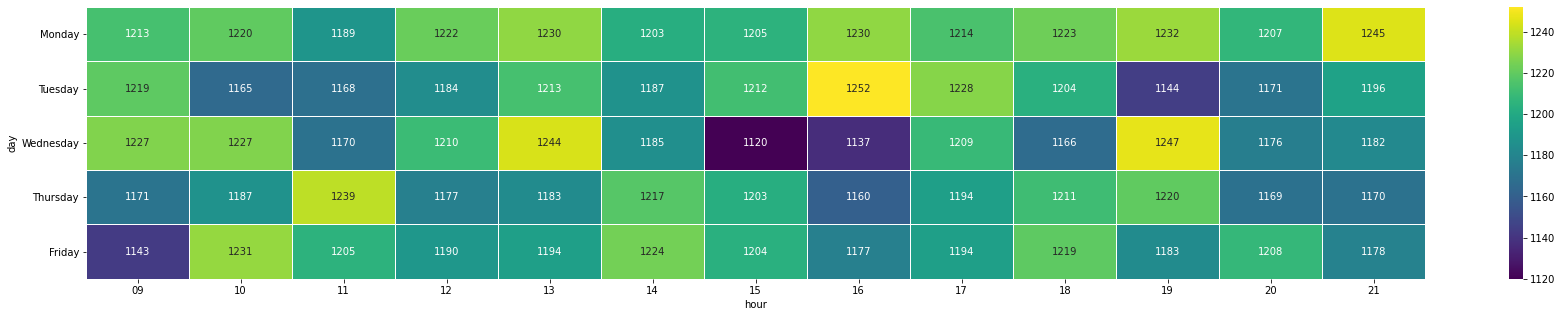

In [12]:
import matplotlib.pyplot as plot
import seaborn as sns

_, ax = plot.subplots(figsize=(30, 5))
heatmap = sns.heatmap(pv, annot=True, fmt='.0f', cmap='viridis', linecolor='white', linewidths='0.5', ax=ax)

Abstract the visualization logic into a function:

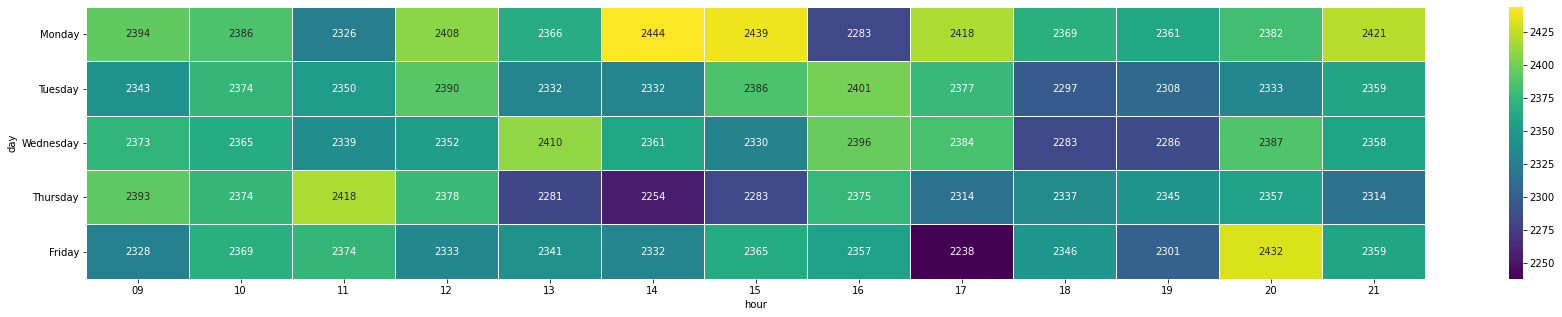

In [13]:
def heatmap(df, col, col_val):
    gb = df.groupby([col, 'day', 'hour'], as_index=False).agg({'device_ids': 'count'})
    pv = gb[gb[col] == col_val].pivot('day', 'hour', 'device_ids')
    _, ax = plot.subplots(figsize=(30, 5))
    h = sns.heatmap(pv, annot=True, fmt='.0f', cmap='viridis', linecolor='white', linewidths='0.5', ax=ax)

heatmap(dedupe, 'region', 'ON')

Apply visualization function through an interactive widget:

In [14]:
import ipywidgets as widgets

def heatmap_val(name):
    return heatmap(dedupe, 'name', name)

i = widgets.interact(heatmap_val, name=dedupe.name.unique().tolist())

interactive(children=(Dropdown(description='name', options=('King-Mendez', 'Wells, Barnes and Washington', 'Ta…

Or even a nested interactive widget of widgets:

In [15]:
def heatmap_col(col):

    def heatmap_val(val):
        return heatmap(dedupe, col, val)

    widgets.interact(heatmap_val, val=dedupe[col].unique().tolist())

i = widgets.interact(heatmap_col, col=['name', 'region'])

interactive(children=(Dropdown(description='col', options=('name', 'region'), value='name'), Output()), _dom_c…

Revise the visualization function to work with multiple dimensions in one pass:

In [16]:
def heatmap_2(df, region = None, name = None):
    cols = []
    conditions = []
    if region and region != 'ALL':
        cols.append('region')
        conditions.append(f'region == "{region}"')
    if name and name != 'ALL':
        cols.append('name')
        conditions.append(f'name == "{name}"')

    conditions = ' & '.join(conditions)
    if conditions:
        df = df.query(conditions)
    
    gb = df.groupby(['day', 'hour'], as_index=False).agg({'device_ids': 'count'})
    pv = gb.pivot('day', 'hour', 'device_ids')
    _, ax = plot.subplots(figsize=(30, 5))
    h = sns.heatmap(pv, annot=True, fmt='.0f', cmap='viridis', linecolor='white', linewidths='0.5', ax=ax)

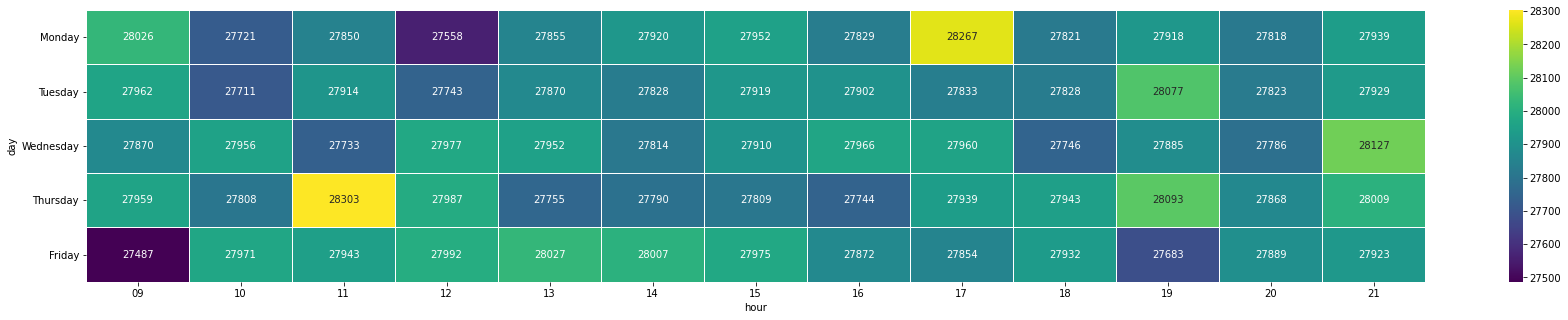

In [17]:
heatmap_2(dedupe, region='ALL', name='ALL')  # same as without region and name

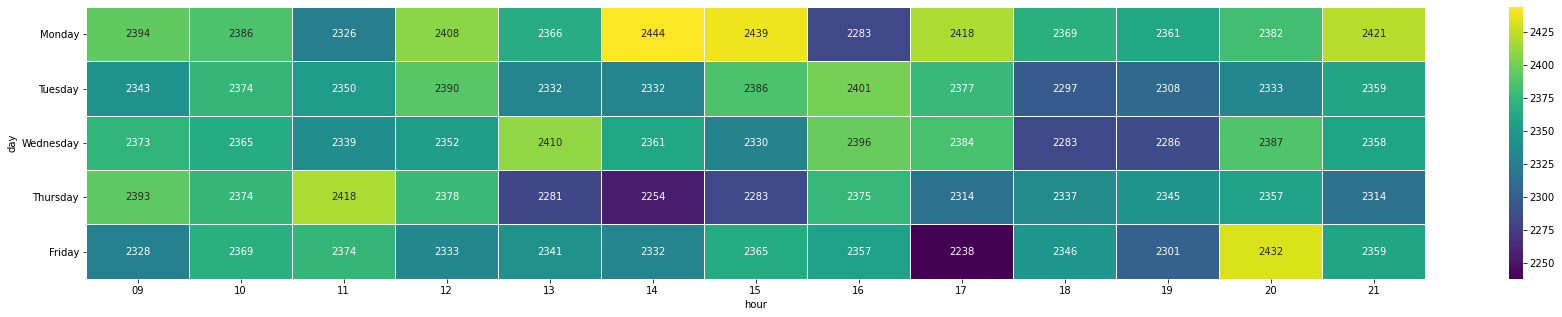

In [18]:
heatmap_2(dedupe, region='ON')

Garcia Ltd


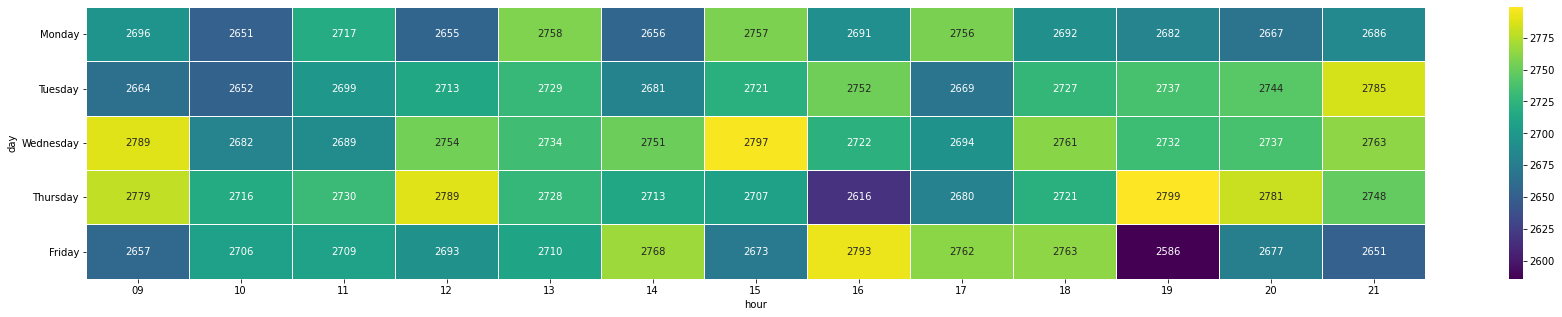

In [19]:
name = random.choice(dedupe.name.unique().tolist())
print(name)
heatmap_2(dedupe, name=name)

region: MB, name: Cook-Jimenez


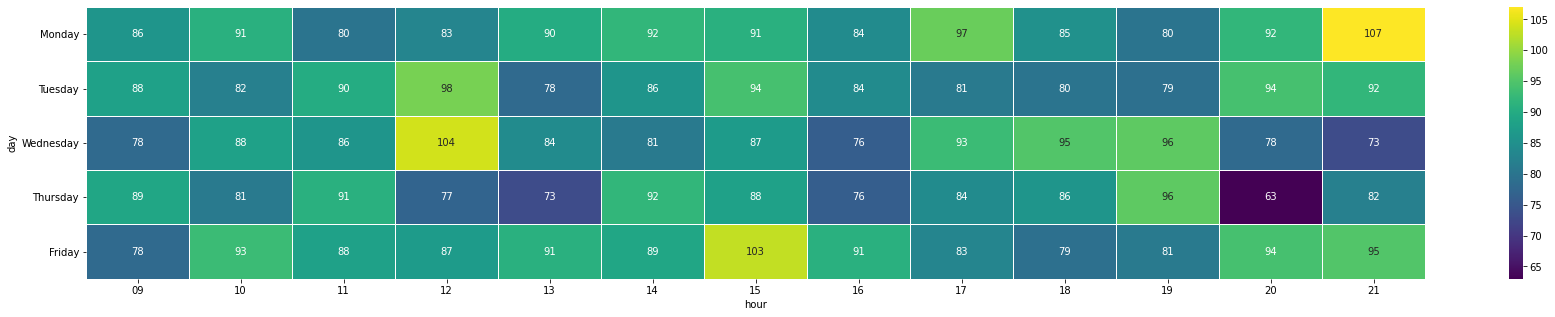

In [20]:
region = random.choice(dedupe.region.unique().tolist())
name = random.choice(dedupe.name.unique().tolist())
print(f'region: {region}, name: {name}')
heatmap_2(dedupe, region=region, name=name)

In [21]:
def heatmap_hof(region, name):
    return heatmap_2(dedupe, region, name)

i = widgets.interact(
    heatmap_hof,
    region=['ALL', *dedupe.region.unique().tolist()],
    name=['ALL', *dedupe.name.unique().tolist()],
)

interactive(children=(Dropdown(description='region', options=('ALL', 'AB', 'QC', 'YT', 'BC', 'ON', 'SK', 'NB',…

## Remarks

With a good understanding of the anticipated data schema, we can leverage generative techniques to:
* Unblock ourselves from idle-waiting for the actual data delivery
* Extend the volume and often statistical comprehensiveness of the data
* Revise data analysis processes to become more robust

## References

* Python built-in [random](https://docs.python.org/3/library/random.html) and [uuid](https://docs.python.org/3/library/uuid.html) modules
* [Faker](https://github.com/joke2k/faker) package
* [09 - Set operations](./09-set-operations.ipynb) and [10 - Bridging Web UI into Notebooks](10-bridging-web-ui-to-notebook.ipynb)